# Time series clustering exercise

# Data

Download the census bureau business data for all years 1993-2014. You can investigate using the API (I have not done it with the census bureau). I did is as you see below

The data is on the github repo. Each file is the economic census for 1 year. 
Download it programmatically and move it to PUIdata

 Download the NYC zipcodes shapefile. One of many ways in which you can get the zipcodes shapefile for NYC
 https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip


## You can use zipfile module in python to unzip the files
it should be installed in your system, but if it is not you can get the code with wget from here
https://github.com/python/cpython/blob/2.7/Lib/zipfile.py
remembering to use the raw link
(or you can use the usual shell commands)

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pylab as pl
import os
import zipfile
import urllib

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
os.environ["PUIDATA"] = "%s/PUIdata"%os.getenv("HOME")
puidata = os.getenv("PUIDATA")

### Download shpfile

In [3]:
url = 'https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip'
fname = 'ZIP_CODE_040114.zip'
urllib.request.urlretrieve(url, fname)
!mv ZIP_CODE_040114.zip $PUIDATA
!unzip -o $PUIDATA/ZIP_CODE_040114.zip -d $PUIDATA

Archive:  /nfshome/jc9033/PUIdata/ZIP_CODE_040114.zip
  inflating: /nfshome/jc9033/PUIdata/ZIP_CODE_040114.shx  
  inflating: /nfshome/jc9033/PUIdata/ZIP_CODE_040114.dbf  
  inflating: /nfshome/jc9033/PUIdata/ZIP_CODE_040114.prj  
  inflating: /nfshome/jc9033/PUIdata/ZIP_CODE_040114.sbn  
  inflating: /nfshome/jc9033/PUIdata/ZIP_CODE_040114.sbx  
  inflating: /nfshome/jc9033/PUIdata/ZIP_CODE_040114.shp  
  inflating: /nfshome/jc9033/PUIdata/ZIP_CODE_040114.shp.xml  


In [4]:
shp = gpd.GeoDataFrame.from_file(os.getenv('PUIDATA')+'/'+'ZIP_CODE_040114.shp')
print(shp.shape)
shp.head()

(263, 13)


ZIPCODE BLDGZIP   PO_NAME  POPULATION          AREA STATE  COUNTY ST_FIPS  \
0   11436       0   Jamaica     18681.0  2.269930e+07    NY  Queens      36   
1   11213       0  Brooklyn     62426.0  2.963100e+07    NY   Kings      36   
2   11212       0  Brooklyn     83866.0  4.197210e+07    NY   Kings      36   
3   11225       0  Brooklyn     56527.0  2.369863e+07    NY   Kings      36   
4   11218       0  Brooklyn     72280.0  3.686880e+07    NY   Kings      36   

  CTY_FIPS                   URL  SHAPE_AREA  SHAPE_LEN  \
0      081  http://www.usps.com/         0.0        0.0   
1      047  http://www.usps.com/         0.0        0.0   
2      047  http://www.usps.com/         0.0        0.0   
3      047  http://www.usps.com/         0.0        0.0   
4      047  http://www.usps.com/         0.0        0.0   

                                            geometry  
0  POLYGON ((1038098.251871482 188138.3800067157,...  
1  POLYGON ((1001613.712964058 186926.4395172149,...  
2  POLYGON ((1011174.275535807 183696.33770971, 1...  
3  POLYGON ((995908.3654508889 183617.6128015518,...  
4  POLYGON ((991997.1134308875 176307.4958601296,...

In [5]:
shp = shp.drop_duplicates("ZIPCODE")
print(shp.shape)

(248, 13)


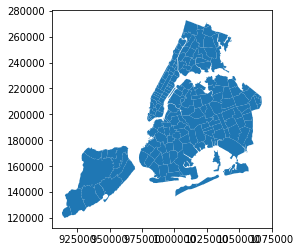

In [6]:
shp.plot()

In [7]:
zipcode = shp['ZIPCODE'].to_frame().astype('int')
print(zipcode.shape)

(248, 1)


### Download census bureau business data 

In [8]:
zipfilelist = list(range(94,100)) + list(range(15))
print(len(zipfilelist))
zipfilelist

21


[94, 95, 96, 97, 98, 99, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [9]:
fnamelist = []
for i in zipfilelist:
    url = 'https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW12_fb55/zbp%02d'%i + 'totals.zip'
    fname = 'zbp%02d'%i + 'totals.zip'
    fnamelist.append(fname)
    urllib.request.urlretrieve(url, fname)
    #!mv $fname $PUIDATA
    #os.rename(fname,$PUIDATA)
    #shutil.move(os.getcwd() + '/' + fname, $PUIDATA)

In [10]:
temp = pd.DataFrame()
for i in zipfilelist:
    fname = 'zbp%02d'%i + 'totals.zip'
    zf = zipfile.ZipFile(fname)
    df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    print('shape of file '+str(i)+' :'+str(df.shape))
    
    temp = pd.DataFrame()
    try:
        temp['est%02d'%i] = df['est']
    except:
        temp['est%02d'%i] = df['EST']
    try:
        temp['zip'] = df['zip']
    except:
        temp['zip'] = df['ZIP']
    
    zipcode = pd.merge(zipcode, temp, left_on='ZIPCODE', right_on='zip', how='left').drop(['zip'],axis=1)

print(zipcode.shape)
zipcode.head()

shape of file 94 :(39259, 7)
shape of file 95 :(39932, 7)
shape of file 96 :(40099, 7)
shape of file 97 :(40248, 7)
shape of file 98 :(39467, 7)
shape of file 99 :(39761, 7)
shape of file 0 :(39853, 7)
shape of file 1 :(39817, 7)
shape of file 2 :(39451, 7)
shape of file 3 :(39423, 7)
shape of file 4 :(39583, 7)
shape of file 5 :(39625, 7)
shape of file 6 :(39657, 7)
shape of file 7 :(39652, 10)
shape of file 8 :(39240, 10)
shape of file 9 :(39174, 10)
shape of file 10 :(39104, 13)
shape of file 11 :(39032, 13)
shape of file 12 :(38818, 13)
shape of file 13 :(38804, 13)
shape of file 14 :(38792, 13)
(248, 22)


ZIPCODE  est94   est95   est96   est97   est98   est99   est00   est01  \
0    11436   51.0    50.0    53.0    51.0    51.0    58.0    65.0    57.0   
1    11213  406.0   420.0   433.0   456.0   476.0   473.0   477.0   493.0   
2    11212  505.0   494.0   502.0   527.0   519.0   541.0   520.0   527.0   
3    11225  381.0   387.0   388.0   410.0   416.0   409.0   417.0   422.0   
4    11218  985.0  1015.0  1049.0  1075.0  1118.0  1149.0  1161.0  1180.0   

    est02   ...     est05   est06   est07   est08   est09   est10   est11  \
0    78.0   ...      82.0    80.0    84.0    90.0    92.0    98.0   101.0   
1   546.0   ...     556.0   565.0   556.0   592.0   621.0   675.0   674.0   
2   577.0   ...     587.0   570.0   587.0   602.0   647.0   699.0   713.0   
3   479.0   ...     491.0   499.0   514.0   520.0   543.0   580.0   597.0   
4  1228.0   ...    1332.0  1331.0  1377.0  1397.0  1457.0  1474.0  1523.0   

    est12   est13   est14  
0    95.0    99.0   109.0  
1   726.0   755.0   772.0  
2   721.0   731.0   752.0  
3   623.0   673.0   696.0  
4  1605.0  1687.0  1736.0  

[5 rows x 22 columns]

In [11]:
!mv *.zip $PUIDATA

### Combine census bureau business data 

# Data cleaning

you may need to clean your data: for some NYC zip codes there may be no info
sanity check: you should have 20 (N_timestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)


IMPORTANT: read the instructions below on pre-processing. Afte rthat:

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



vals.mean(axis=1) should return 0 (or something very small) everywhere

vals.mean(axis=1).shape should be (260,)

vals.std(axis=1) should return 1 everywhere

vals.std(axis=1).shape

## TASKS:
    
    1. get and prep your data.
    
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means
    in **a few** clusters (as discussed there is no real good, sound way to 
    decide what a good number is here. try a few options, keeping in mind 
    a few is more than a couple, but i recommand you stay within the 
    single digit numbers)
    
    3. plot the cluster centers (if you used K means those are the means of 
    the clusters). you can plot for example the cluster centers overlayed on 
    each time series (using the alpha channel to control the opacity in the 
    plot may be helpful here).
    
    4. Use another clustering algorithm (of your choice)
    
    5. overlay your data on a NYC map: you can use shapefiles for the 
    zip codes and different colors for different clusters
    
    6. Compare the results of the 2 algorithms
    
    7. attempt an interpretation. this is dangerous ground: clustering is 
    an exploratory tool so you do not want to jump to conclusions because 
    you see some clusters! but seeing structure in your data can inform 
    your next moves as an investigator. 
    

Note on preprocessing: the preparation of these data should include the "standardization" of the time seris. 
*Always when you apply a machine learning model you should standardize the data or whiten it.*
These operations may be complicated preprocessing operation, they can for example invoke PCA, and they are aimed at removing covariance in the feature space.

The simplest version of whitening *standardizes each feature*" from every column (feature) you subtract the mean and you divide it by the standard deviation.

But the time series preprocessing is different if you want to use each time stamp as feature: because you want to maintain the coherence of the data, i.e. you **do not want** to treat each feature as an independent feature! the pattenrs in the time series are what you are clustering on (time series goes up and down, creating a pattern) and those patterns would be lost by whitening.

*So when you cluster or otherwise use a time series in a model, using each timestamp as a feature, you want to standardize the observations, not the features.* 

**From each row of your table (observation, in this case each zipcode) subtract the mean and you divide the row by the standard deviation.**

In [12]:
print("ZIPCODES:",
      len(np.unique(shp.ZIPCODE)), "POLYGONS:",
      len(shp.ZIPCODE),
      "the difference is due to island with same zip as parts of land,",
      "but disjoint shapes")
nyczips = shp.ZIPCODE.values.astype(int)
print("number of NYC zip codes:", len(nyczips))

ZIPCODES: 248 POLYGONS: 248 the difference is due to island with same zip as parts of land, but disjoint shapes
number of NYC zip codes: 248


In [13]:
# 20 years of data and 263 zipcodes
cbs = zipcode.copy()
cbs.index = cbs.ZIPCODE
cbs = cbs.drop(['ZIPCODE'],axis=1)
print(cbs.shape)
cbs.head()

(248, 21)


est94   est95   est96   est97   est98   est99   est00   est01  \
ZIPCODE                                                                  
11436     51.0    50.0    53.0    51.0    51.0    58.0    65.0    57.0   
11213    406.0   420.0   433.0   456.0   476.0   473.0   477.0   493.0   
11212    505.0   494.0   502.0   527.0   519.0   541.0   520.0   527.0   
11225    381.0   387.0   388.0   410.0   416.0   409.0   417.0   422.0   
11218    985.0  1015.0  1049.0  1075.0  1118.0  1149.0  1161.0  1180.0   

          est02   est03   ...     est05   est06   est07   est08   est09  \
ZIPCODE                   ...                                             
11436      78.0    74.0   ...      82.0    80.0    84.0    90.0    92.0   
11213     546.0   569.0   ...     556.0   565.0   556.0   592.0   621.0   
11212     577.0   581.0   ...     587.0   570.0   587.0   602.0   647.0   
11225     479.0   488.0   ...     491.0   499.0   514.0   520.0   543.0   
11218    1228.0  1247.0   ...    1332.0  1331.0  1377.0  1397.0  1457.0   

          est10   est11   est12   est13   est14  
ZIPCODE                                          
11436      98.0   101.0    95.0    99.0   109.0  
11213     675.0   674.0   726.0   755.0   772.0  
11212     699.0   713.0   721.0   731.0   752.0  
11225     580.0   597.0   623.0   673.0   696.0  
11218    1474.0  1523.0  1605.0  1687.0  1736.0  

[5 rows x 21 columns]

In [14]:
#cleaning all missing values
cleancsb = cbs.dropna(axis=0, how='all').fillna(value=0)
cleancsb.shape

(245, 21)

In [15]:
#then the standardization will look like:
vals = ((cleancsb.T - cleancsb.mean(1)) / cleancsb.std(1)).T
vals.head()

est94     est95     est96     est97     est98     est99     est00  \
ZIPCODE                                                                         
11436   -1.296083 -1.347340 -1.193568 -1.296083 -1.296083 -0.937280 -0.578478   
11213   -1.433782 -1.305462 -1.186307 -0.975496 -0.792181 -0.819678 -0.783015   
11212   -1.077974 -1.210216 -1.114040 -0.813490 -0.909666 -0.645182 -0.897644   
11225   -1.223282 -1.159696 -1.149098 -0.915948 -0.852361 -0.926545 -0.841764   
11218   -1.474935 -1.336988 -1.180649 -1.061095 -0.863371 -0.720826 -0.665648   

            est01     est02     est03    ...        est05     est06     est07  \
ZIPCODE                                  ...                                    
11436   -0.988538  0.087870 -0.117160    ...     0.292900  0.190385  0.395415   
11213   -0.636364 -0.150580  0.060232    ...    -0.058923  0.023569 -0.058923   
11212   -0.813490 -0.212389 -0.164301    ...    -0.092169 -0.296543 -0.092169   
11225   -0.788775 -0.184704 -0.089324    ...    -0.057531  0.027251  0.186217   
11218   -0.578281 -0.357567 -0.270200    ...     0.120649  0.116050  0.327569   

            est08     est09     est10     est11     est12     est13     est14  
ZIPCODE                                                                        
11436    0.702960  0.805475  1.113020  1.266793  0.959248  1.164278  1.676853  
11213    0.271044  0.536850  1.031799  1.022634  1.499252  1.765058  1.920875  
11212    0.088161  0.629152  1.254297  1.422605  1.518781  1.639001  1.891464  
11225    0.249804  0.493552  0.885668  1.065830  1.341371  1.871258  2.115007  
11218    0.419533  0.695427  0.773596  0.998909  1.375964  1.753018  1.978331  

[5 rows x 21 columns]

In [16]:
print(vals.mean(axis=1).head())
print()
print(vals.std(axis=1).head())

ZIPCODE
11436   -3.595008e-16
11213   -1.268826e-16
11212    4.652363e-16
11225   -1.903239e-16
11218   -2.537653e-16
dtype: float64

ZIPCODE
11436    1.0
11213    1.0
11212    1.0
11225    1.0
11218    1.0
dtype: float64


# Algorithm 1. Cluster with kmeans

### 5 clusters with kmeans

In [17]:
#each observation in the km object has a label: 
#that is the cluster assigned to that observation
nc = 5
km5 = KMeans(n_clusters=nc, random_state=444).fit(vals)

print(km5.labels_.shape)
print(type(km5.labels_))
km5.labels_

(245,)
<class 'numpy.ndarray'>


array([3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 2, 2, 0, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3,
       3, 1, 0, 0, 3, 3, 3, 0, 3, 0, 0, 4, 0, 3, 0, 3, 1, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 0, 2, 1, 0, 0, 4, 3, 3, 4, 3, 0, 3, 3, 3, 3, 3, 0,
       1, 4, 3, 3, 4, 3, 1, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 0, 3, 0, 2, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 0, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 0, 3, 3, 3, 0, 3, 3, 3, 2, 3, 3, 3, 3, 0, 3, 3, 3, 3,
       3, 3, 3, 0, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 0, 4, 1, 2, 2, 1, 3, 1, 3,
       3, 3, 1, 0, 3, 3, 4, 1, 2, 2, 1, 1, 4, 0, 1, 4, 1, 3, 1, 1, 3, 2, 1,
       3, 1, 2, 4, 1, 4, 1, 1, 1, 1, 1, 1, 2, 3, 2, 0, 2, 4, 4, 1, 2, 2, 1,
       3, 1, 4, 2, 1, 1, 0, 0, 3, 4, 4, 2, 3, 4, 0], dtype=int32)

In [18]:
kmlabel5 = pd.DataFrame(km5.labels_)
kmlabel5.head()

0
0  3
1  3
2  3
3  3
4  3

In [19]:
kmlabel5_dictionary = {}
for i in range(nc):
    kmlabel5_dictionary[i] = list(kmlabel5[kmlabel5 == i].dropna().index)
    print(len(kmlabel5_dictionary[i]))

34
30
18
144
19


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: irow(i) is deprecated. Please use .iloc[i]
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: irow(i) is deprecated. Please use .iloc[i]


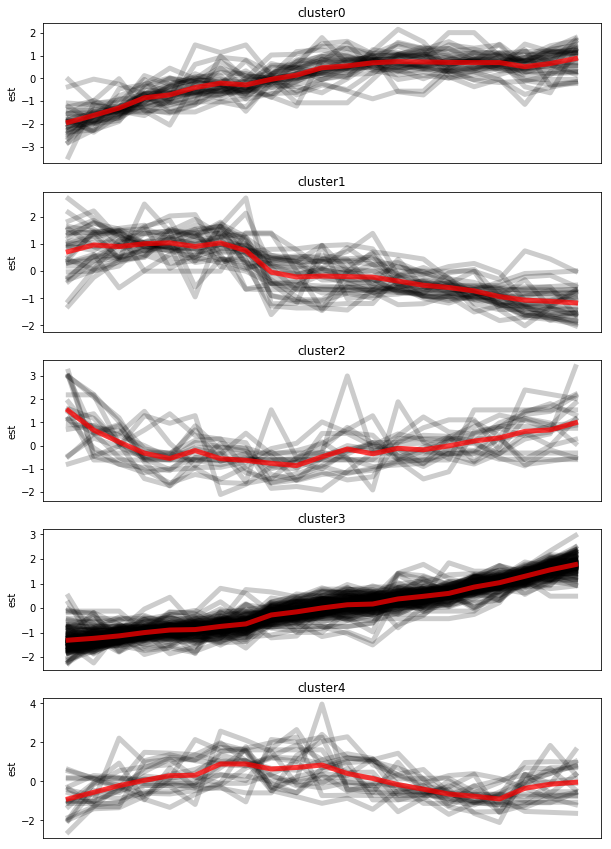

In [20]:
fig = plt.figure(figsize=(10,15))
for i in range(nc):
    for j in kmlabel5_dictionary[i]:        
        ax = fig.add_subplot(5,1,i+1)
        ax.plot(range(21), vals.irow(j), 'black', alpha=0.2, linewidth=5)
    ax.plot(range(21), vals.irow(kmlabel5_dictionary[i]).mean(axis=0), 'r', alpha=0.75, linewidth=5)
    ax.set_ylabel('est')
    ax.set_xticks([])
    #ax.set_xlabel('year')
    ax.set_title('cluster%d'%i)

### Figure 1_1: 
5 k-means clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes.

In [21]:
kmlabel5_zipcode = kmlabel5.copy()
kmlabel5_zipcode.index = vals.index
kmlabel5_zipcode.columns=['km5']
kmlabel5_zipcode.reset_index(inplace=True)
kmlabel5_zipcode['ZIPCODE'] = kmlabel5_zipcode['ZIPCODE'].astype('str')
print(type(kmlabel5_zipcode['ZIPCODE'][0]))
print(type(shp['ZIPCODE'][0]))
kmlabel5_zipcode.head()

<class 'str'>
<class 'str'>


ZIPCODE  km5
0   11436    3
1   11213    3
2   11212    3
3   11225    3
4   11218    3

In [22]:
shp = pd.merge(shp, kmlabel5_zipcode, on='ZIPCODE', how='inner')
print(shp.shape)
shp.head()

(245, 14)


ZIPCODE BLDGZIP   PO_NAME  POPULATION          AREA STATE  COUNTY ST_FIPS  \
0   11436       0   Jamaica     18681.0  2.269930e+07    NY  Queens      36   
1   11213       0  Brooklyn     62426.0  2.963100e+07    NY   Kings      36   
2   11212       0  Brooklyn     83866.0  4.197210e+07    NY   Kings      36   
3   11225       0  Brooklyn     56527.0  2.369863e+07    NY   Kings      36   
4   11218       0  Brooklyn     72280.0  3.686880e+07    NY   Kings      36   

  CTY_FIPS                   URL  SHAPE_AREA  SHAPE_LEN  \
0      081  http://www.usps.com/         0.0        0.0   
1      047  http://www.usps.com/         0.0        0.0   
2      047  http://www.usps.com/         0.0        0.0   
3      047  http://www.usps.com/         0.0        0.0   
4      047  http://www.usps.com/         0.0        0.0   

                                            geometry  km5  
0  POLYGON ((1038098.251871482 188138.3800067157,...    3  
1  POLYGON ((1001613.712964058 186926.4395172149,...    3  
2  POLYGON ((1011174.275535807 183696.33770971, 1...    3  
3  POLYGON ((995908.3654508889 183617.6128015518,...    3  
4  POLYGON ((991997.1134308875 176307.4958601296,...    3

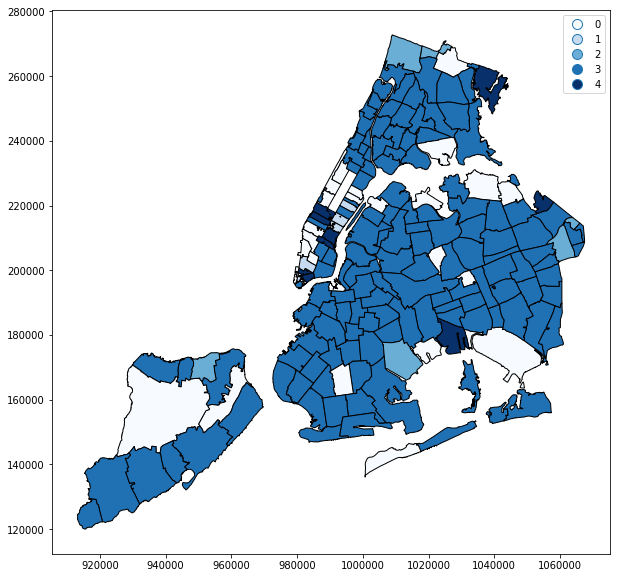

In [23]:
fig = plt.figure(figsize=(10,10))
ax = ax = fig.add_subplot(111)
shp.plot(column = 'km5', cmap='Blues',edgecolor='black',legend=True,categorical=True, ax=ax)

### Figure 1_2: 
cloropleth of  cluster centers for 5 k-means clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster.

### 3 clusters with kmeans

In [24]:
def KM(nc, vals, shp):
    km = KMeans(n_clusters=nc, random_state=444).fit(vals)
    kmlabel = pd.DataFrame(km.labels_)
    kmlabel_dictionary = {}
    for i in range(nc):
        kmlabel_dictionary[i] = list(kmlabel[kmlabel == i].dropna().index)

    fig = plt.figure(figsize=(10,15))
    for i in range(nc):
        for j in kmlabel_dictionary[i]:        
            ax = fig.add_subplot(nc,1,i+1)
            ax.plot(range(21), vals.irow(j), 'black', alpha=0.2, linewidth=5)
        ax.plot(range(21), vals.irow(kmlabel_dictionary[i]).mean(axis=0), 'r', alpha=0.75, linewidth=5)
        ax.set_ylabel('est')
        ax.set_xticks([])
        ax.set_title('cluster%d'%i)
        
    kmlabel_zipcode = kmlabel.copy()
    kmlabel_zipcode.index = vals.index
    kmlabel_zipcode.columns=['km%d'%nc]
    kmlabel_zipcode.reset_index(inplace=True)
    kmlabel_zipcode['ZIPCODE'] = kmlabel_zipcode['ZIPCODE'].astype('str')
    shp = pd.merge(shp, kmlabel_zipcode, on='ZIPCODE', how='inner')

    fig = plt.figure(figsize=(10,10))
    ax = ax = fig.add_subplot(111)
    shp.plot(column = 'km%d'%nc, cmap='Blues',edgecolor='black',legend=True,categorical=True, ax=ax)
    
    return shp

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:12: FutureWarning: irow(i) is deprecated. Please use .iloc[i]
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:13: FutureWarning: irow(i) is deprecated. Please use .iloc[i]


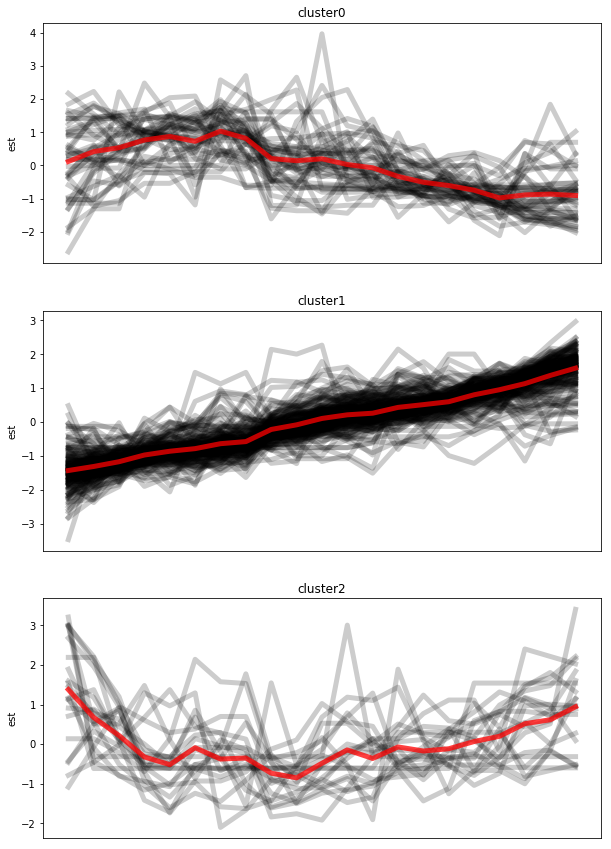

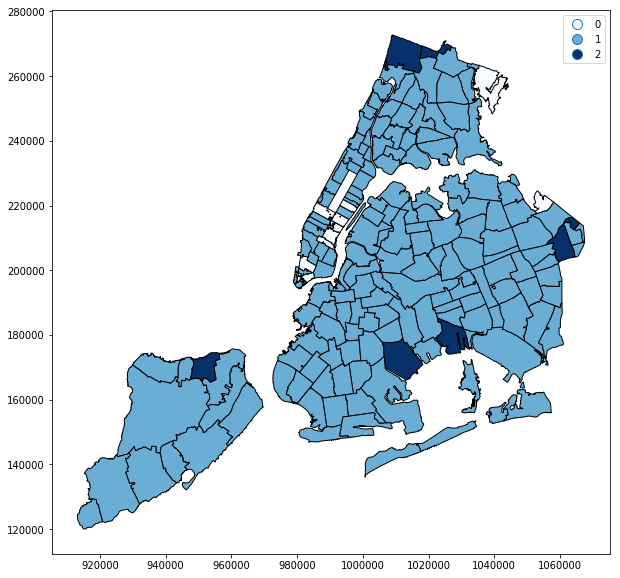

In [25]:
shp = KM(3, vals, shp)

### Figure 2: 
cloropleth of  cluster centers for 3 k-means clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. The business pattern time series are plotted at the top.

### 7 clusters with kmeans

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:12: FutureWarning: irow(i) is deprecated. Please use .iloc[i]
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:13: FutureWarning: irow(i) is deprecated. Please use .iloc[i]


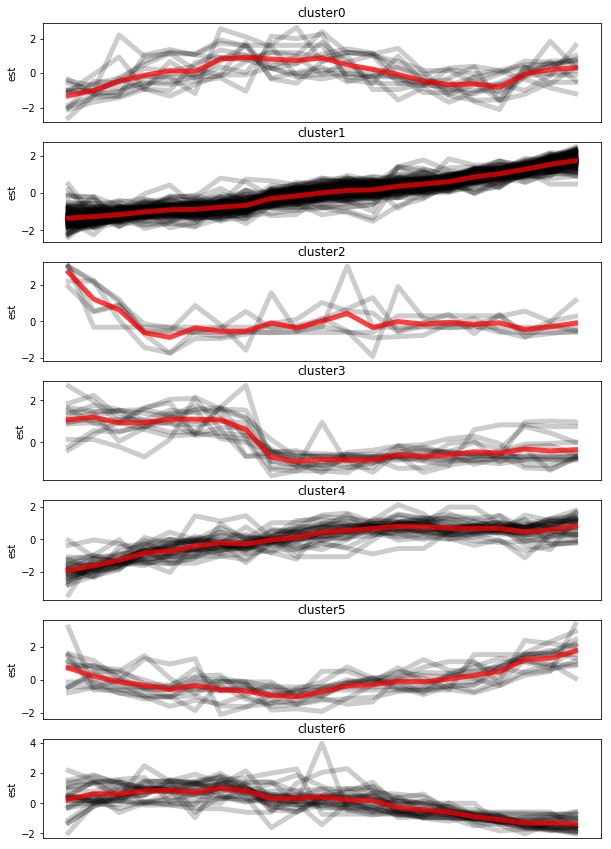

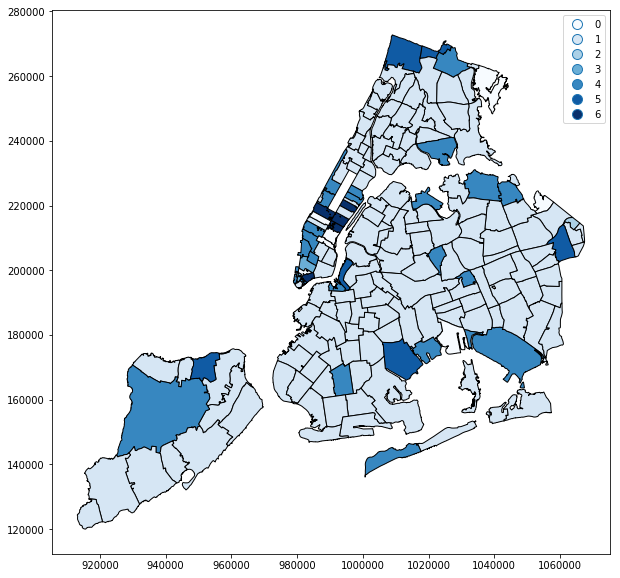

In [26]:
shp = KM(7, vals, shp)

### Figure 3: 
cloropleth of  cluster centers for 7 k-means clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. The business pattern time series are plotted at the top.

****

# Algorithm 2. Hierarchical agglomerative clustering in 7 clusters

### 7 clusters with Hierarchical Agglomeration

In [27]:
nc = 7
agc = AgglomerativeClustering(n_clusters=nc, linkage='average').fit(vals)
labelsag = agc.labels_
#centroidsag = np.zeros((nc, vals.shape[1]))
print(labelsag.shape)
labelsag

(245,)


array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 5, 1, 0, 3, 3, 5, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3,
       4, 5, 3, 3, 0, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 2, 0, 0, 4, 3, 0, 3, 0, 3,
       3, 3, 0, 3, 3, 3, 5, 0, 4, 1, 0, 0, 5, 3, 0, 4, 0, 3, 0, 0, 3, 3, 4,
       3, 0, 1, 5, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 3, 3, 4, 2, 2, 0, 1, 1, 0,
       3, 0, 5, 3, 0, 0, 3, 3, 3, 5, 2, 3, 3, 5, 3])

In [28]:
agc_label_7 = pd.DataFrame(labelsag)
agc_label_7.head()

0
0  3
1  3
2  3
3  3
4  3

In [29]:
agc_label_7_dictionary = {}
for i in range(nc):
    agc_label_7_dictionary[i] = list(agc_label_7[agc_label_7 == i].dropna().index)
    print(len(agc_label_7_dictionary[i]))

32
6
5
184
6
11
1


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: irow(i) is deprecated. Please use .iloc[i]
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: irow(i) is deprecated. Please use .iloc[i]


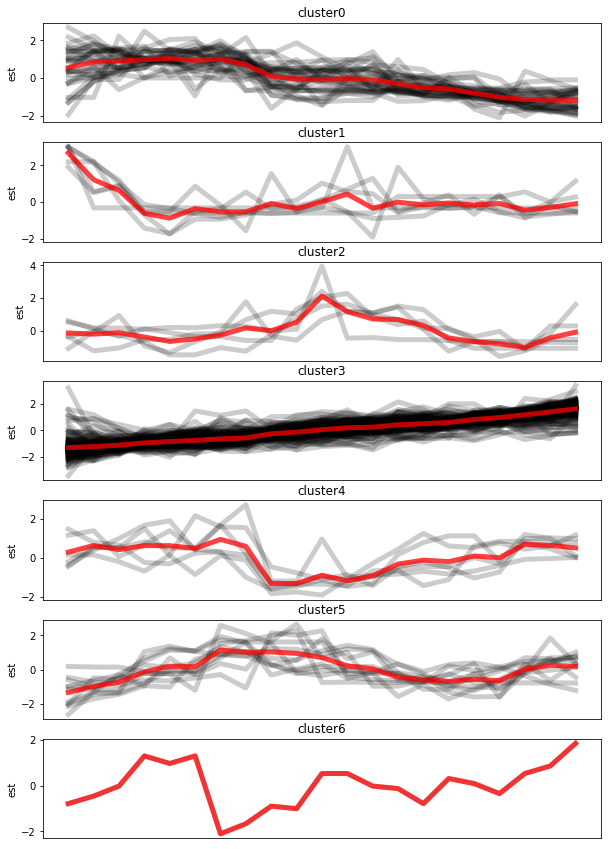

In [30]:
fig = plt.figure(figsize=(10,15))
for i in range(nc):
    for j in agc_label_7_dictionary[i]:        
        ax = fig.add_subplot(7,1,i+1)
        ax.plot(range(21), vals.irow(j), 'black', alpha=0.2, linewidth=5)
    ax.plot(range(21), vals.irow(agc_label_7_dictionary[i]).mean(axis=0), 'r', alpha=0.75, linewidth=5)
    ax.set_ylabel('est')
    ax.set_xticks([])
    #ax.set_xlabel('year')
    ax.set_title('cluster%d'%i)

### Figure 4_1: 
7 hierarchical agglomerative clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes.

In [31]:
agc_label_7_zipcode = agc_label_7.copy()
agc_label_7_zipcode.index = vals.index
agc_label_7_zipcode.columns=['agc7']
agc_label_7_zipcode.reset_index(inplace=True)
agc_label_7_zipcode['ZIPCODE'] = agc_label_7_zipcode['ZIPCODE'].astype('str')
print(type(agc_label_7_zipcode['ZIPCODE'][0]))
print(type(shp['ZIPCODE'][0]))
agc_label_7_zipcode.head()

<class 'str'>
<class 'str'>


ZIPCODE  agc7
0   11436     3
1   11213     3
2   11212     3
3   11225     3
4   11218     3

In [32]:
shp = pd.merge(shp, agc_label_7_zipcode, on='ZIPCODE', how='inner')
print(shp.shape)
shp.head()

(245, 17)


ZIPCODE BLDGZIP   PO_NAME  POPULATION          AREA STATE  COUNTY ST_FIPS  \
0   11436       0   Jamaica     18681.0  2.269930e+07    NY  Queens      36   
1   11213       0  Brooklyn     62426.0  2.963100e+07    NY   Kings      36   
2   11212       0  Brooklyn     83866.0  4.197210e+07    NY   Kings      36   
3   11225       0  Brooklyn     56527.0  2.369863e+07    NY   Kings      36   
4   11218       0  Brooklyn     72280.0  3.686880e+07    NY   Kings      36   

  CTY_FIPS                   URL  SHAPE_AREA  SHAPE_LEN  \
0      081  http://www.usps.com/         0.0        0.0   
1      047  http://www.usps.com/         0.0        0.0   
2      047  http://www.usps.com/         0.0        0.0   
3      047  http://www.usps.com/         0.0        0.0   
4      047  http://www.usps.com/         0.0        0.0   

                                            geometry  km5  km3  km7  agc7  
0  POLYGON ((1038098.251871482 188138.3800067157,...    3    1    1     3  
1  POLYGON ((1001613.712964058 186926.4395172149,...    3    1    1     3  
2  POLYGON ((1011174.275535807 183696.33770971, 1...    3    1    1     3  
3  POLYGON ((995908.3654508889 183617.6128015518,...    3    1    1     3  
4  POLYGON ((991997.1134308875 176307.4958601296,...    3    1    1     3

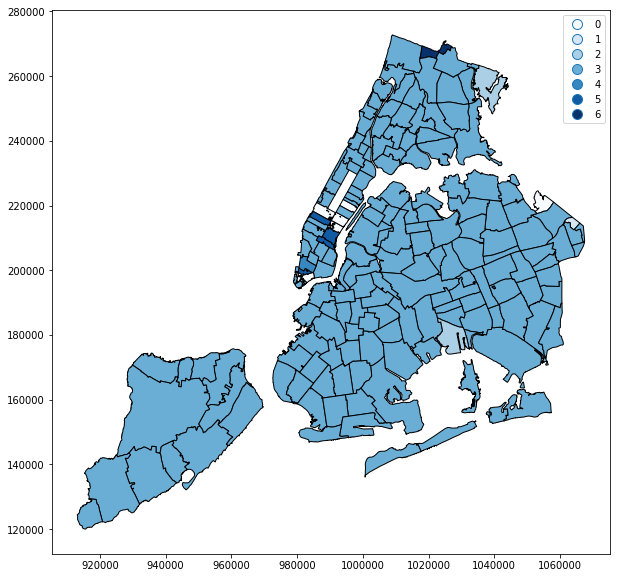

In [33]:
fig = plt.figure(figsize=(10,10))
ax = ax = fig.add_subplot(111)
shp.plot(column = 'agc7', cmap='Blues',edgecolor='black',legend=True,categorical=True, ax=ax)

### Figure 4_2: 
cloropleth of  cluster centers for 7 hierarchical agglomerative clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster.

### Figure 9: 
As figures 3, 5, 7 for hierarchical agglomerative clustering in 7 clusters, with smoothed time series

### 5 clusters with Hierarchical Agglomeration

In [34]:
def AGC(nc, vals, shp):
    agc = AgglomerativeClustering(n_clusters=nc, linkage='average').fit(vals)
    labelsag = agc.labels_

    agc_label = pd.DataFrame(labelsag)

    agc_label_dictionary = {}
    for i in range(nc):
        agc_label_dictionary[i] = list(agc_label[agc_label == i].dropna().index)

    fig = plt.figure(figsize=(10,15))
    for i in range(nc):
        for j in agc_label_dictionary[i]:        
            ax = fig.add_subplot(nc,1,i+1)
            ax.plot(range(21), vals.irow(j), 'black', alpha=0.2, linewidth=5)
        ax.plot(range(21), vals.irow(agc_label_dictionary[i]).mean(axis=0), 'r', alpha=0.75, linewidth=5)
        ax.set_ylabel('est')
        ax.set_xticks([])
        ax.set_title('cluster%d'%i)

    agc_label_zipcode = agc_label.copy()
    agc_label_zipcode.index = vals.index
    agc_label_zipcode.columns=['agc%d'%nc]
    agc_label_zipcode.reset_index(inplace=True)
    agc_label_zipcode['ZIPCODE'] = agc_label_zipcode['ZIPCODE'].astype('str')

    shp = pd.merge(shp, agc_label_zipcode, on='ZIPCODE', how='inner')

    fig = plt.figure(figsize=(10,10))
    ax = ax = fig.add_subplot(111)
    shp.plot(column = 'agc%d'%nc, cmap='Blues',edgecolor='black',legend=True,categorical=True, ax=ax)
    
    return shp

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:15: FutureWarning: irow(i) is deprecated. Please use .iloc[i]
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:16: FutureWarning: irow(i) is deprecated. Please use .iloc[i]


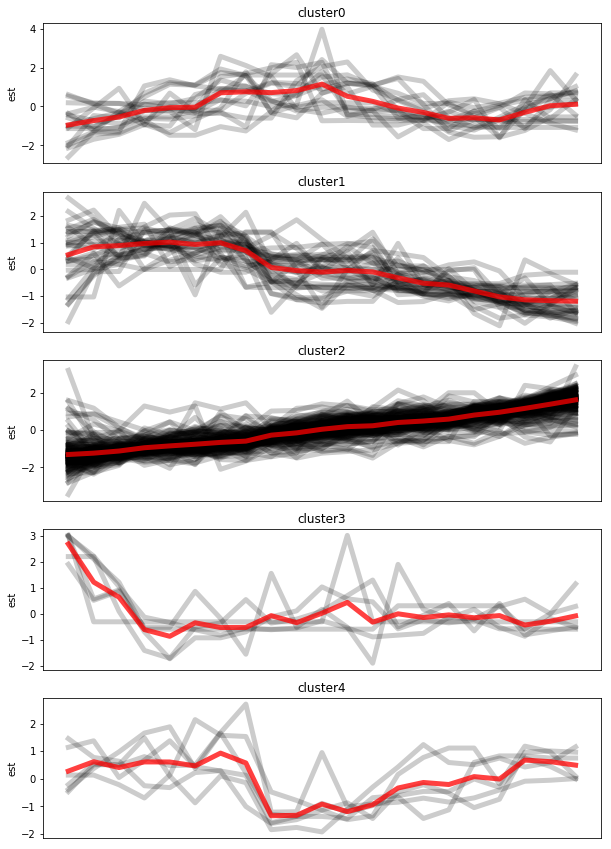

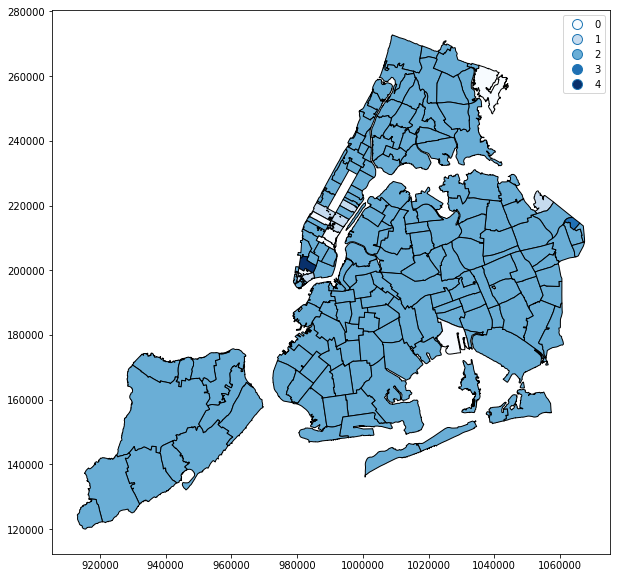

In [35]:
shp = AGC(5, vals, shp)

### Figure 5: 
cloropleth of  cluster centers for 5 hierarchical agglomerative clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. The business pattern time series are plotted at the top.

### 3 clusters with Hierarchical Agglomeration

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:15: FutureWarning: irow(i) is deprecated. Please use .iloc[i]
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:16: FutureWarning: irow(i) is deprecated. Please use .iloc[i]


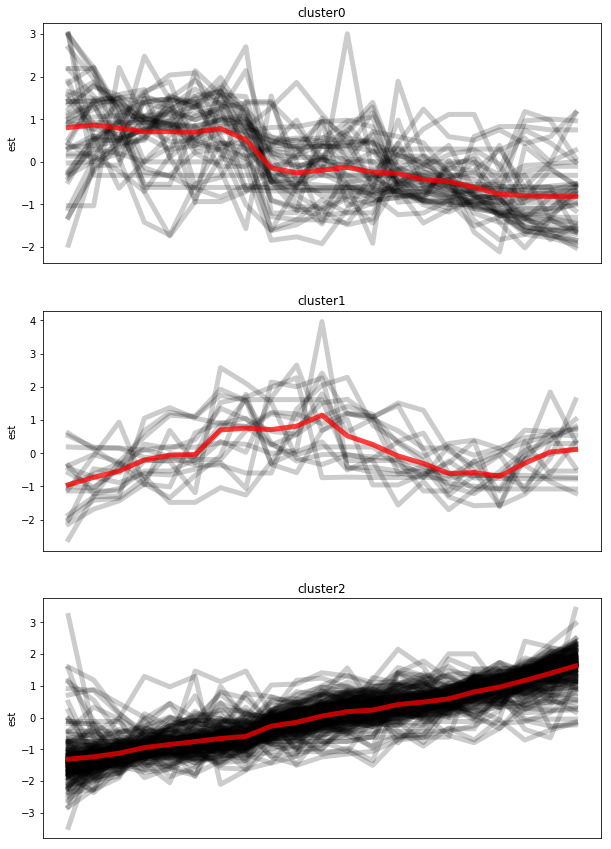

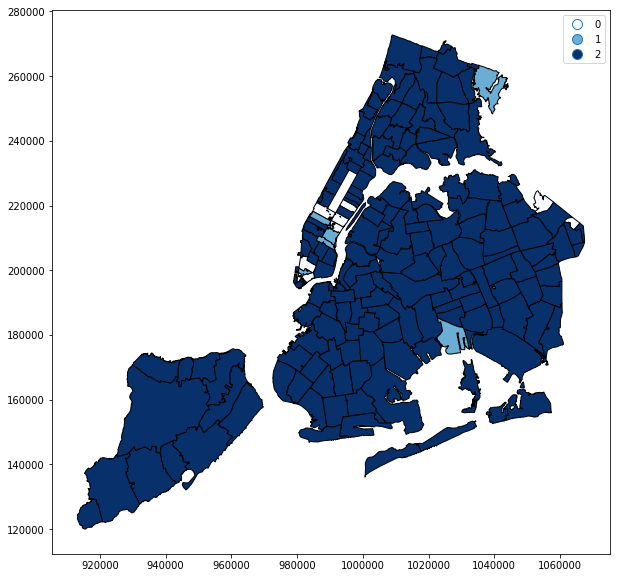

In [36]:
shp = AGC(3, vals, shp)

### Figure 6: 
cloropleth of  cluster centers for 3 hierarchical agglomerative clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. The business pattern time series are plotted at the top.

****
# Algorithm 3.hierarchical clustering in scipy

### And if you use hierarchical clustering in scipy you can make a dandrogram it may look like this:

In [37]:
zipcodes = list(shp['ZIPCODE'])
type(zipcodes)

list

(array([   5,   15,   25,   35,   45,   55,   65,   75,   85,   95,  105,
         115,  125,  135,  145,  155,  165,  175,  185,  195,  205,  215,
         225,  235,  245,  255,  265,  275,  285,  295,  305,  315,  325,
         335,  345,  355,  365,  375,  385,  395,  405,  415,  425,  435,
         445,  455,  465,  475,  485,  495,  505,  515,  525,  535,  545,
         555,  565,  575,  585,  595,  605,  615,  625,  635,  645,  655,
         665,  675,  685,  695,  705,  715,  725,  735,  745,  755,  765,
         775,  785,  795,  805,  815,  825,  835,  845,  855,  865,  875,
         885,  895,  905,  915,  925,  935,  945,  955,  965,  975,  985,
         995, 1005, 1015, 1025, 1035, 1045, 1055, 1065, 1075, 1085, 1095,
        1105, 1115, 1125, 1135, 1145, 1155, 1165, 1175, 1185, 1195, 1205,
        1215, 1225, 1235, 1245, 1255, 1265, 1275, 1285, 1295, 1305, 1315,
        1325, 1335, 1345, 1355, 1365, 1375, 1385, 1395, 1405, 1415, 1425,
        1435, 1445, 1455, 1465, 1475, 

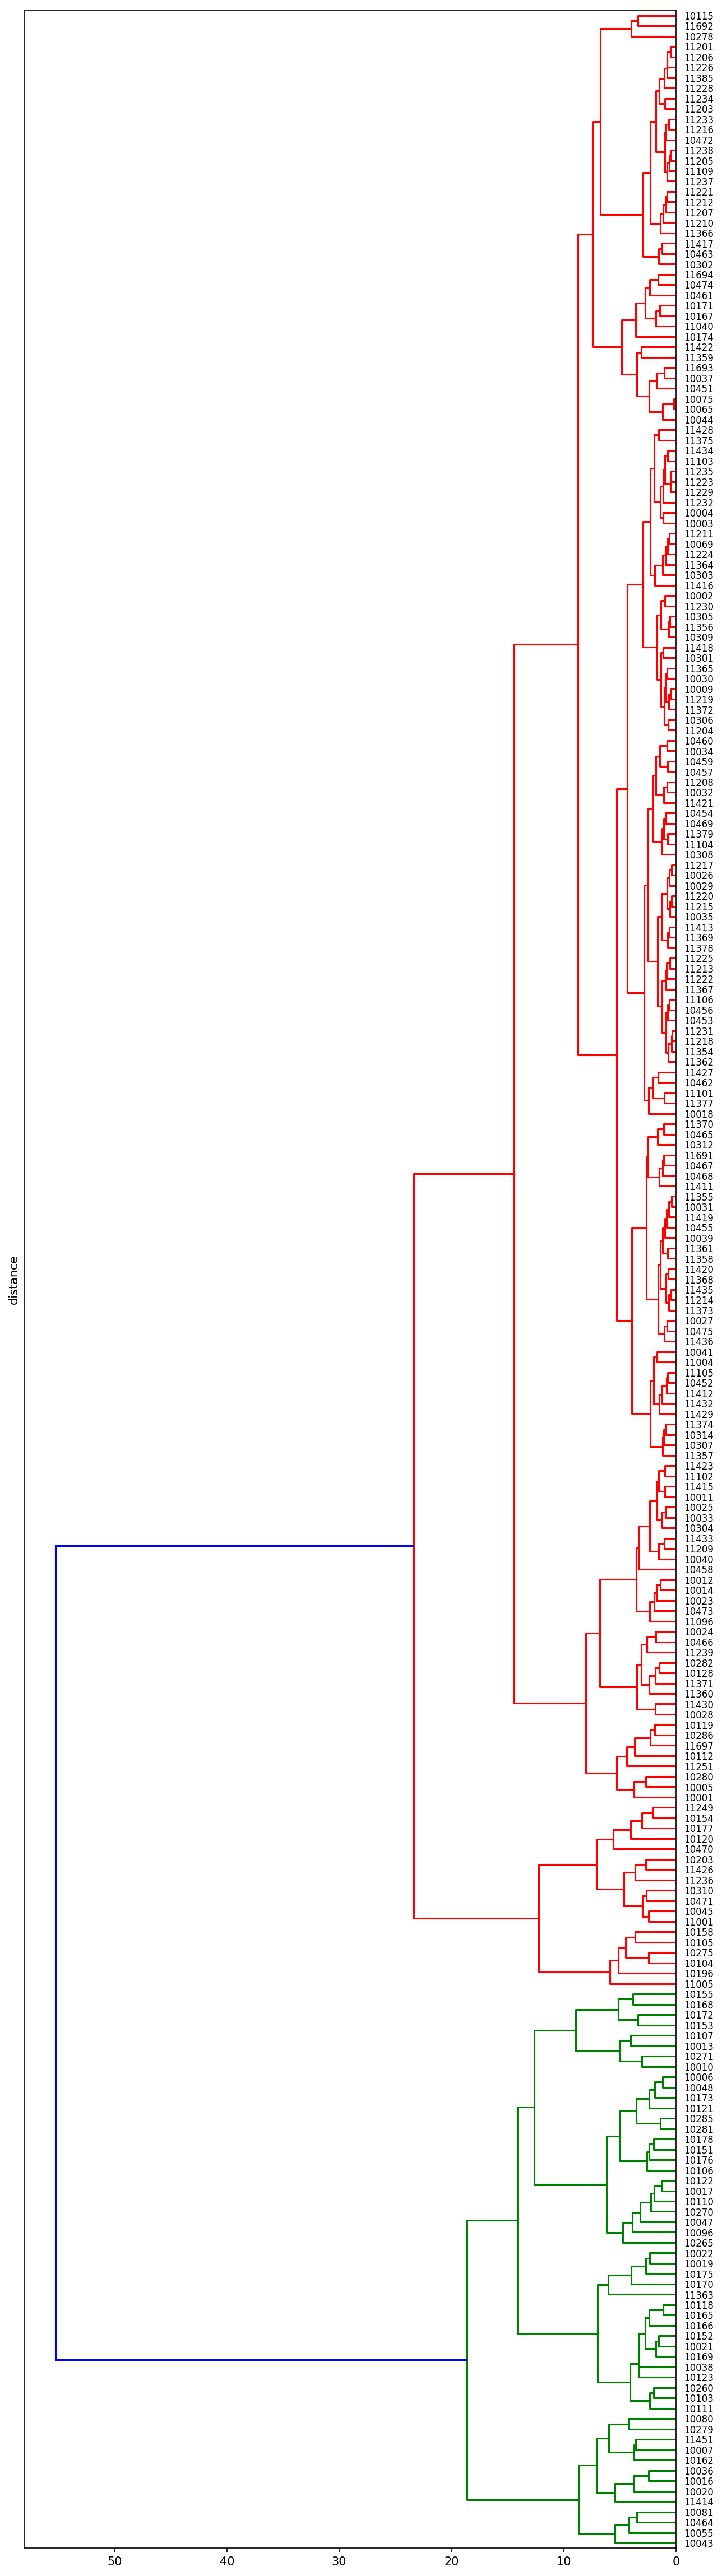

In [38]:
import scipy.cluster as scp
fig = pl.figure(figsize=(10,40), dpi=150)
pl.ylabel("distance")
ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage(vals, method='ward'),
                               labels = zipcodes,
                               leaf_rotation=90.,  # rotates the x axis labels
                               leaf_font_size=8.,  # font size for the x axis labels)
                               orientation='left')
pl.yticks(rotation=0)

### Figure 7: 
Dandrogram of number of establishments clusters, eucledian distance in lat-lon space, Ward linkage.

****
# Compare Algorithm 2 & 3: kmeans VS Hierarchical agglomerative clustering

In [39]:
def COMPARE(nc, vals, shp):
    #K-means Clustering
    fig = plt.figure(figsize=(20,10))
    ax = ax = fig.add_subplot(121)
    shp.plot(column = 'km%d'%nc, cmap='Blues',edgecolor='black',legend=True,categorical=True, ax=ax)
    ax.set_title(str(nc)+' K-means Clustering', fontsize=20)
    # Agglomerative Clustering
    ax = ax = fig.add_subplot(122)
    shp.plot(column = 'agc%d'%nc, cmap='Blues',edgecolor='black',legend=True,categorical=True, ax=ax)
    ax.set_title(str(nc)+' Agglomerative Clustering', fontsize=20)

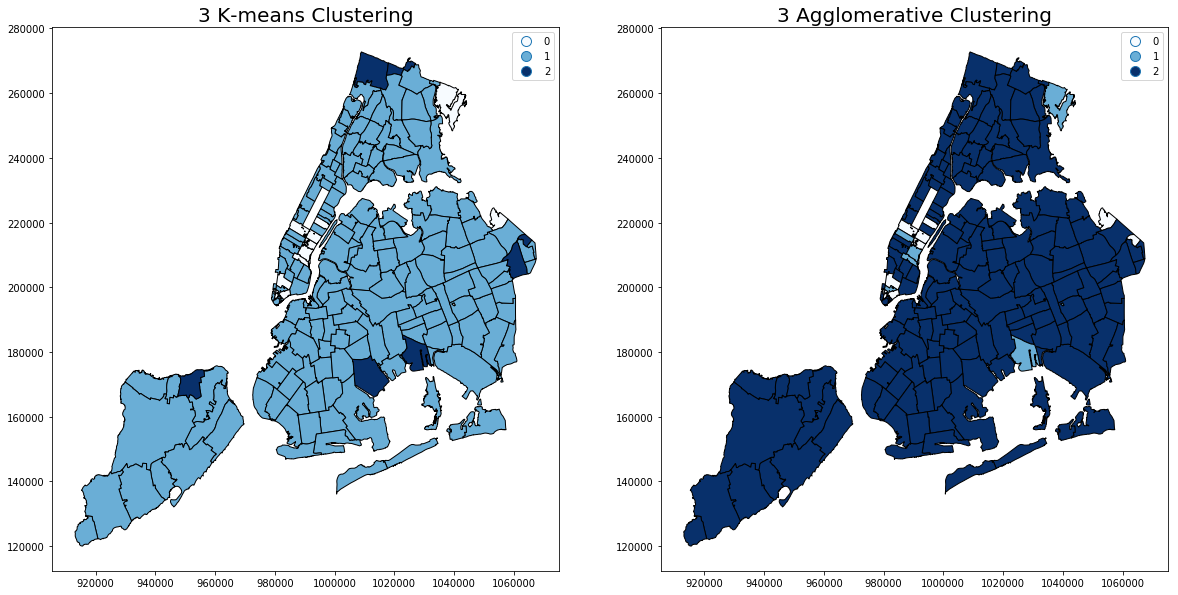

In [40]:
COMPARE(3, vals, shp)

### Figure 8: 
Comparison of the results of the 2 algorithms: 3 kmeans VS Hierarchical agglomerative clustering

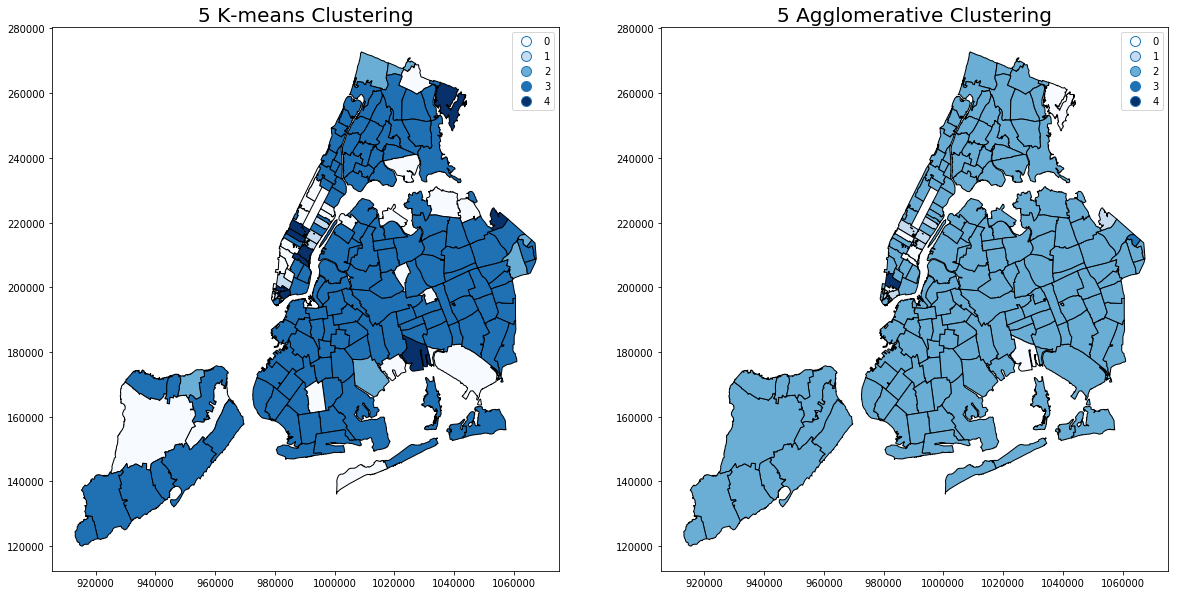

In [41]:
COMPARE(5, vals, shp)

### Figure 9: 
Comparison of the results of the 2 algorithms: 5 kmeans VS Hierarchical agglomerative clustering

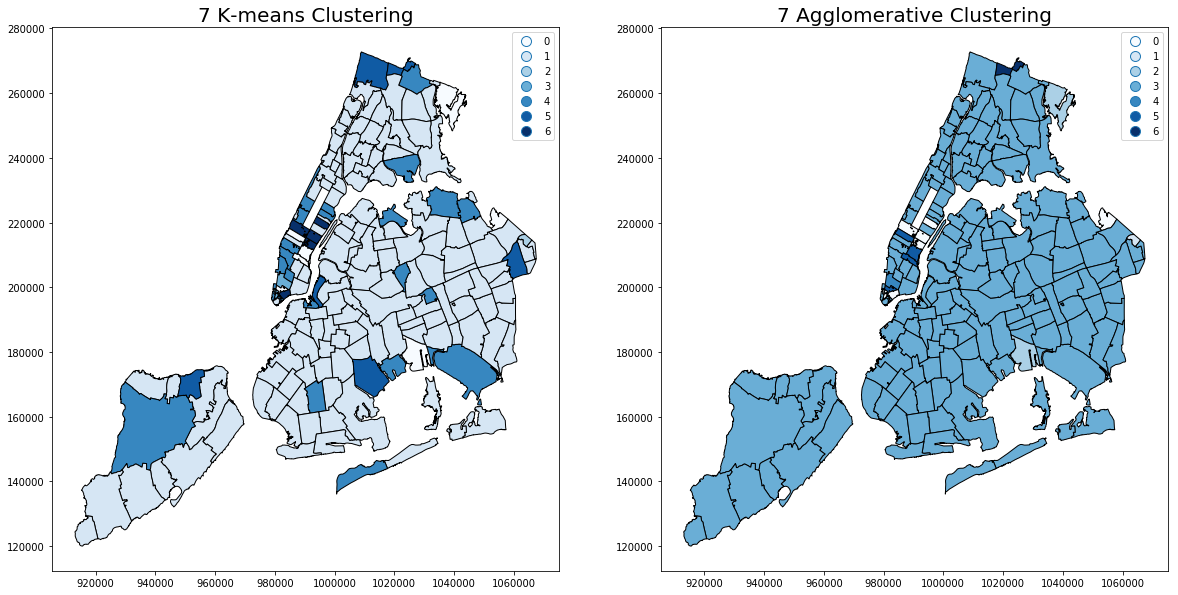

In [42]:
COMPARE(7, vals, shp)

### Figure 10: 
Comparison of the results of the 2 algorithms: 7 kmeans VS Hierarchical agglomerative clustering

***
# Interpretation:
### In general, kmeans and hierarchical agglomerative clustering output similar results. But there are also lots of differences in specific areas between the results of these 2 algorithms. Specifically, hierarchical agglomerative clustering has more smooth clustering result. 